## Plot the overall performance of the models trained on the motor cortex data

This notebook covers Figure 4BCD, S14

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import h5py

### Map cell populations

The data is annotated at three different resolutions. Map the subclasses to the correct class.

In [2]:
filename = '../../Zenodo/human/M1/class/class.csv'
classes = np.array(pd.read_csv(filename, index_col=0).columns, dtype='str')

filename = '../../Zenodo/human/M1/subclass/subclass.csv'
subclasses = np.array(pd.read_csv(filename, index_col=0).columns, dtype='<U20')

ct_mapping = np.vstack([subclasses, subclasses, subclasses])
ct_mapping[0,:] = 'All'
ct_mapping[1,[0,1,11,12,13,18]] = 'Non-neuronal'
ct_mapping[1,[10,14,15,16,17,19]] = 'GABAergic'
ct_mapping[1,[2,3,4,5,6,7,8,9]] = 'Glutamatergic'
ct_mapping

array([['All', 'All', 'All', 'All', 'All', 'All', 'All', 'All', 'All',
        'All', 'All', 'All', 'All', 'All', 'All', 'All', 'All', 'All',
        'All', 'All'],
       ['Non-neuronal', 'Non-neuronal', 'Glutamatergic', 'Glutamatergic',
        'Glutamatergic', 'Glutamatergic', 'Glutamatergic',
        'Glutamatergic', 'Glutamatergic', 'Glutamatergic', 'GABAergic',
        'Non-neuronal', 'Non-neuronal', 'Non-neuronal', 'GABAergic',
        'GABAergic', 'GABAergic', 'GABAergic', 'Non-neuronal',
        'GABAergic'],
       ['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
        'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro-PVM', 'OPC',
        'Oligo', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip']],
      dtype='<U20')

### Calculate performance of three types of models when prediction gene expression of a subclass

Performance of the tissue-specific, class-specific, and subclass-specific model when predicting subclass expression values. See Figure 4A for the setup.

In [3]:
# Performance of the 3 models (we need this for figure 4B)
corr_all = pd.DataFrame(np.zeros((len(subclasses)*20*3,3)),
                       columns = ['Model', 'Cell population', 'Corr'])
corr_all = corr_all.astype({"Model": str, "Cell population": str})

# Save the prediction of the subclass models (we need this later on for figure 4CD)
y_true_all = pd.DataFrame(np.zeros((18138, 20)), columns=subclasses)
y_pred_all = pd.DataFrame(np.zeros((18138, 20)), columns=subclasses)
y_pred_all2 = pd.DataFrame(np.zeros((18138, 20)), columns=subclasses)
y_pred_all3 = pd.DataFrame(np.zeros((18138, 20)), columns=subclasses)
fold = pd.DataFrame(np.zeros((18138, 20)), columns=subclasses)

count_all=0

for i, ct in enumerate(subclasses):
    
    y_true_all_ = []
    y_pred_all_ = []
    y_pred_all2_ = []
    y_pred_all3_ = []
    fold_ = []
    total_rerun = 0
    
    for j in range(20):

        y_pred_sc = 0
        y_pred_c = 0
        y_pred_t = 0
        
        # Read true values & pred values by subclass model for that celltype
        for k in range(5):
            file_sc = '../../Zenodo/human/M1/subclass/logmean_multitask_' + str(j) + '/logs_dir' + str(k) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file_sc)
            y_true = np.asarray(y['y_true'])[:,i]
            y_pred = np.asarray(y['y_pred'])[:,i]
            y_pred_sc = y_pred_sc + y_pred/5
        
        # Read pred values by class level
        # Look which column we have to select
        for k in range(5):
            file_c = '../../Zenodo/human/M1/class/logmean_multitask_' + str(j) + '/logs_dir' + str(k) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file_c)
            pop_c = ct_mapping[1,i]
            idx_c = np.where(classes == pop_c)[0]
            y_pred = np.asarray(y['y_pred'])[:,idx_c[0]]
            y_pred_c += y_pred/5
                
        # Read pred values by tissue level
        for k in range(5):
            
            file_t = '../../Zenodo/human/M1/tissue/logmean_All_' + str(j) + '/logs_dir' + str(k) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file_t)
            y_pred = np.asarray(y['y_pred'])
            y_pred_t += y_pred/5
            

        corr_sc, _ = pearsonr(y_true, y_pred_sc)
        corr_c, _ = pearsonr(y_true, y_pred_c)
        corr_t, _ = pearsonr(y_true, y_pred_t)
                
        corr_all['Model'].values[count_all] = 'Subclass'
        corr_all['Cell population'].values[count_all] = ct
        corr_all['Corr'].values[count_all] = corr_sc
        count_all += 1
        
        corr_all['Model'].values[count_all] = 'Class'
        corr_all['Cell population'].values[count_all] = ct
        corr_all['Corr'].values[count_all] = corr_c
        count_all += 1
        
        corr_all['Model'].values[count_all] = 'Tissue'
        corr_all['Cell population'].values[count_all] = ct
        corr_all['Corr'].values[count_all] = corr_t
        count_all += 1
        
        y_true_all_.extend(y_true)
        y_pred_all_.extend(y_pred_sc)
        y_pred_all2_.extend(y_pred_c)
        y_pred_all3_.extend(y_pred_t)
        fold_.extend(np.ones_like(y_true)*j)
    
    y_true_all[ct] = y_true_all_
    y_pred_all[ct] = y_pred_all_
    y_pred_all2[ct] = y_pred_all2_
    y_pred_all3[ct] = y_pred_all3_
    fold[ct] = fold_

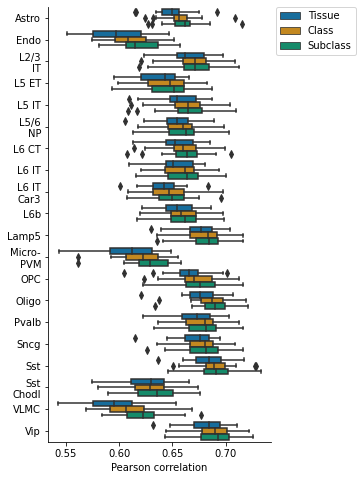

In [4]:
# Figure 4B
fig, ax = plt.subplots(figsize=[4,8])
sns.boxplot(data=corr_all, y='Cell population', x='Corr', hue='Model', palette='colorblind',
           hue_order = ['Tissue', 'Class', 'Subclass'])
sns.despine()
plt.ylabel('')
ax.set_yticklabels(['Astro', 'Endo', 'L2/3\nIT', 'L5 ET', 'L5 IT', 'L5/6\nNP', 'L6 CT',
       'L6 IT', 'L6 IT\nCar3', 'L6b', 'Lamp5', 'Micro-\nPVM', 'OPC', 'Oligo',
       'Pvalb', 'Sncg', 'Sst', 'Sst\nChodl', 'VLMC', 'Vip'])
plt.xlabel('Pearson correlation')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Check similarity between subclass and class/tissue

Pearson correlation between true expression values (Figure S10)

In [5]:
corr_true = pd.DataFrame(np.zeros((len(subclasses)*20*2,3)),
                       columns = ['Model', 'Cell population', 'Corr'])
corr_true = corr_true.astype({"Model": str, "Cell population": str})

count_all=0

# Next, make predictions for subclass using this ids
for i, ct in enumerate(subclasses):
    
    for j in range(20):

        y_pred_sc = 0
        y_pred_c = 0
        y_pred_t = 0
        
        # Read true values by subclass model for that celltype
        file_sc = '../../Zenodo/human/M1/subclass/logmean_multitask_' + str(j) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file_sc)
        y_true = np.asarray(y['y_true'])[:,i]
        
        # Read true values by class level
        # Look which column we have to select
        file_c = '../../Zenodo/human/M1/class/logmean_multitask_' + str(j) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file_c)
        pop_c = ct_mapping[1,i]
        idx_c = np.where(classes == pop_c)[0]
        y_true_c = np.asarray(y['y_true'])[:,idx_c[0]]

        
        # Read true values by tissue level
        file_t = '../../Zenodo/human/M1/tissue/logmean_All_' + str(j) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file_t)
        y_true_t = np.asarray(y['y_true'])
        
        corr_c, _ = pearsonr(y_true, y_true_c)
        corr_t, _ = pearsonr(y_true, y_true_t)
        
        corr_true['Model'].values[count_all] = 'Class'
        corr_true['Cell population'].values[count_all] = ct
        corr_true['Corr'].values[count_all] = corr_c
        count_all += 1
        
        corr_true['Model'].values[count_all] = 'Tissue'
        corr_true['Cell population'].values[count_all] = ct
        corr_true['Corr'].values[count_all] = corr_t
        count_all += 1


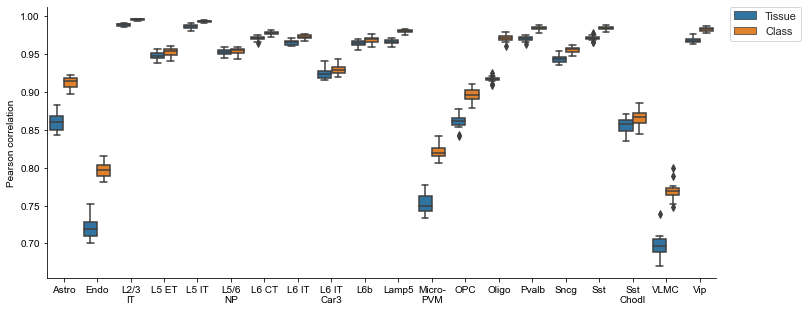

In [6]:
# Figure S14
fig, ax = plt.subplots(figsize=[12,5])
sns.set_style("ticks")
sns.set_context("notebook")

sns.boxplot(data=corr_true, x='Cell population', y='Corr', hue='Model',
           hue_order = ['Tissue', 'Class'])
sns.despine()
ax.set_xticklabels(['Astro', 'Endo', 'L2/3\nIT', 'L5 ET', 'L5 IT', 'L5/6\nNP', 'L6 CT',
       'L6 IT', 'L6 IT\nCar3', 'L6b', 'Lamp5', 'Micro-\nPVM', 'OPC', 'Oligo',
       'Pvalb', 'Sncg', 'Sst', 'Sst\nChodl', 'VLMC', 'Vip'])

plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Correlation across the subclasses

For every gene, we calculate the pearson correlation across the subclasses (Figure 4BC). 

First, we need to link the gene nemes to the predictions and undo the z-score. 

In [7]:
hf = h5py.File('../../Zenodo/human/human_seq_hl.h5', 'r', libver='latest', swmr=True)
gn = np.asarray(hf['geneName']).astype('U30')
hf.close()

#### Link gene names to the predictions

In [8]:
from sklearn.model_selection import KFold

numgenes = 18138
idx_all = np.arange(0,numgenes)
kf = KFold(n_splits=20, shuffle=True, random_state=1)
counter=0
counter2=0
gn_order=np.zeros_like(gn)

## Add a list here with genenames that are in the training set
gn_train = []

## Add a list here with genenames that are in the test set
gn_test = []

for train_val_idx, idx_test in kf.split(idx_all):
    gn_order[counter:(counter+len(idx_test))] = gn[idx_test]
    counter += len(idx_test)
    np.random.seed(counter2)
    counter2 += 1
    idx_rest = np.random.permutation(numgenes-len(idx_test))
    idx_val = train_val_idx[idx_rest[:1000]]
    idx_train = train_val_idx[idx_rest[1000:]]
    
    gn_train.append(gn[idx_train])
    gn_test.append(gn[idx_test])
    

In [9]:
y_true_all.index = gn_order
y_pred_all.index = gn_order
y_pred_all2.index = gn_order
y_pred_all3.index = gn_order
fold.index = gn_order

In [10]:
y_true_logmean = pd.read_csv('../../Zenodo/human/M1/subclass/subclass.csv', index_col=0)
y_true_logmean = y_true_logmean.loc[gn_order]

#### Undo z-score

In [11]:
import copy as cp
from sklearn.preprocessing import StandardScaler

y_true_org = pd.DataFrame(np.zeros_like(y_true_all), index=y_true_all.index, columns=y_true_all.columns)
y_pred_org = pd.DataFrame(np.zeros_like(y_true_all), index=y_true_all.index, columns=y_true_all.columns)
y_pred_org2 = pd.DataFrame(np.zeros_like(y_true_all), index=y_true_all.index, columns=y_true_all.columns)
y_pred_org3 = pd.DataFrame(np.zeros_like(y_true_all), index=y_true_all.index, columns=y_true_all.columns)

for i in range(20):
    
    # Learn zscore from training data
    scaler = StandardScaler()
    scaler.fit(y_true_logmean.loc[gn_train[i]])

    # Training y_true_all & y_pred_all back
    y_pred_org.loc[gn_test[i]] = scaler.inverse_transform(y_pred_all.loc[gn_test[i]])
    y_pred_org2.loc[gn_test[i]] = scaler.inverse_transform(y_pred_all2.loc[gn_test[i]])
    y_pred_org3.loc[gn_test[i]] = scaler.inverse_transform(y_pred_all3.loc[gn_test[i]])
    y_true_org.loc[gn_test[i]] = scaler.inverse_transform(y_true_all.loc[gn_test[i]])
    

#### Calculate correlation for each gene

In [12]:
from tqdm.notebook import tqdm

g_corr = np.zeros((18138,))
p_corr = np.zeros((18138,))

for i,g in tqdm(enumerate(y_true_all.index)):
    
    try:
        
        x,p = pearsonr(np.squeeze(y_true_org.loc[g].values), np.squeeze(y_pred_org.loc[g].values))
        g_corr[i] = x    
        p_corr[i] = p
    except:
        print('nan')
        g_corr[i] = float('NaN')
        p_corr[i] = float('NaN')

0it [00:00, ?it/s]

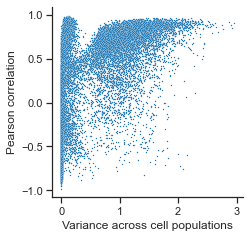

In [13]:
# Figure 4C
g_var = np.var(y_true_org, axis=1)

fig, ax = plt.subplots(figsize=[3.5,3.5])
h = sns.scatterplot(x = g_var.values, y=g_corr, s=2, rasterized=True)
ax.set_box_aspect(1)
sns.despine()
h.set(xlabel='Variance across cell populations', ylabel='Pearson correlation')
plt.show()

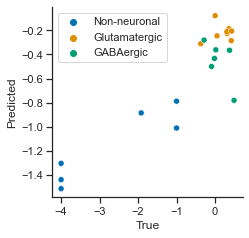

In [14]:
# Figure 4D
g = 'CACNA1I'

fig, ax = plt.subplots(figsize=[3.5,3.5])
sns.scatterplot(x=y_true_org.loc[g], y=y_pred_org.loc[g], hue=ct_mapping[1], rasterized=True, palette='colorblind')
ax.set_box_aspect(1)
sns.despine()
plt.ylabel('Predicted')
plt.xlabel('True')

plt.show()
